Learn iterator for multiphase elastic problems using PAC-FEANet

In [1]:
import pacnet.pac as pac

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ThermalDataSet

In [2]:
device_predict = torch.device('cpu') #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

Test PAC-FEANet for thermal problems

In [4]:
model_name = 'thermal_type1_2d_33x33'
training_set = ThermalDataSet('data/thermal/thermal_type1_2d_33x33.h5', device)
model_dir = 'model/learn_iterator/thermal_type1'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

bs = 16
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

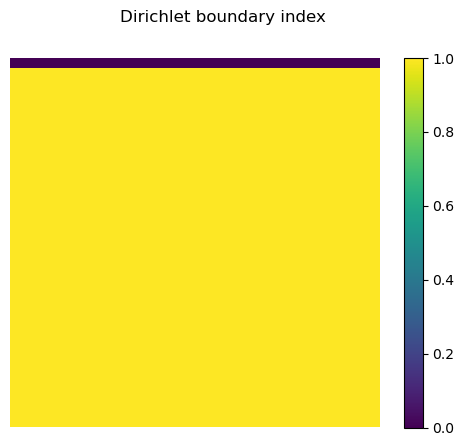

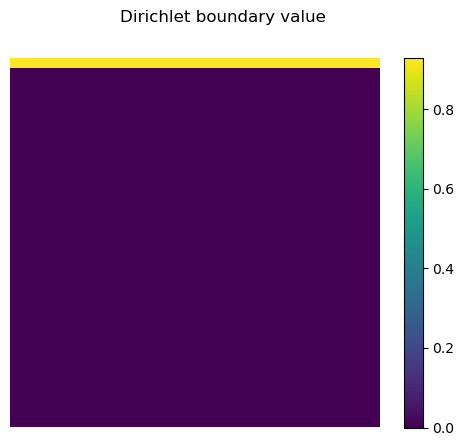

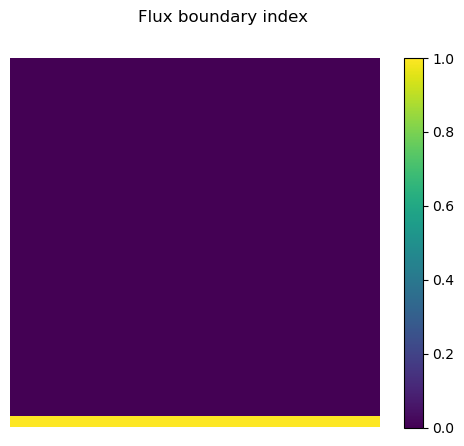

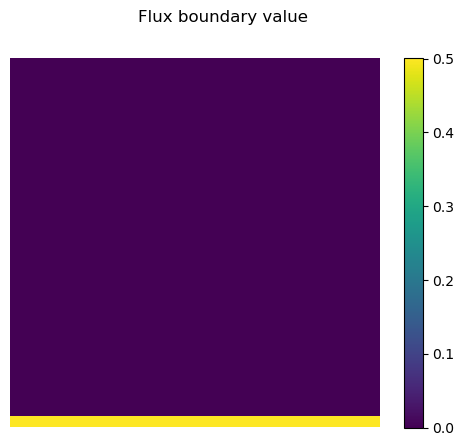

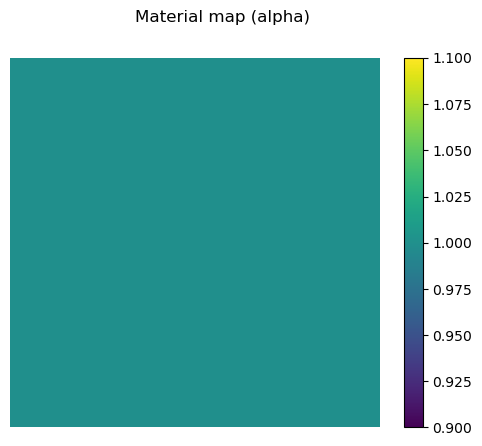

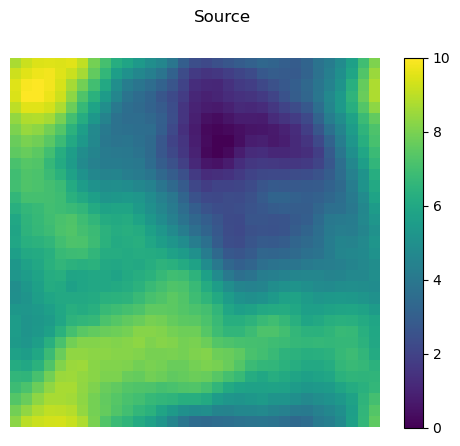

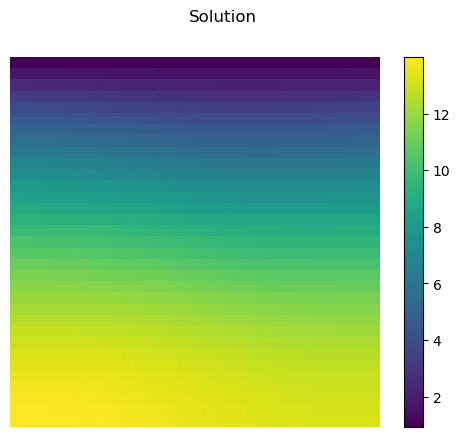

In [5]:
plot.plot_thermalfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_idx_train[k], ftitle='Flux boundary index')
plot.plot_thermalfield(neumann_value_train[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_train[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(f_train[k], ftitle='Source')
plot.plot_thermalfield(u_train[k], ftitle='Solution')

In [6]:
dirich_value_train[k]

tensor([[[0.9281, 0.9281, 0.9281,  ..., 0.9281, 0.9281, 0.9281],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0', dtype=torch.float64)

In [7]:
neumann_value_train[k]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5011, 0.5011, 0.5011,  ..., 0.5011, 0.5011, 0.5011]]],
       device='cuda:0', dtype=torch.float64)

In [8]:
domain_size = 2
n_elem = 2**5
ku, kf = 1, 1
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='thermal', dev=device_predict)

In [9]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 0.732643063485908
1 0.6946982678839084
2 0.6867970003427513
3 0.683489507128999
4 0.6814898121074351
5 0.6799852623702461
6 0.6787076061436611
7 0.6775509757721333
8 0.6764680401071729
9 0.6754355191025009
10 0.674441010037538
11 0.6734774048508554
12 0.6725403287095747
13 0.671626889224596
14 0.6707350344222451
15 0.6698632094201576
16 0.6690101663666034
17 0.6681748559681165
18 0.6673563638099985
19 0.6665538719250526
20 0.6657666349267268
21 0.6649939647218908
22 0.6642352203792689
23 0.6634898011577366
24 0.6627571415114917
25 0.6620367073597243
26 0.6613279931852482
27 0.6606305196916485
28 0.6599438318482903
29 0.6592674972136326
30 0.658601104465139
31 0.6579442620878765
32 0.6572965971890762
33 0.6566577544156874
34 0.6560273949584539
35 0.6554051956303142
36 0.654790848009887
37 0.6541840576428244
38 0.653584543295262
39 0.6529920362546374
40 0.6524062796739
41 0.651827027955722
42 0.6512540461737352
43 0.6506871095281814
44 0.6501260028336224
45 0.6495705200365722
46 0.6490

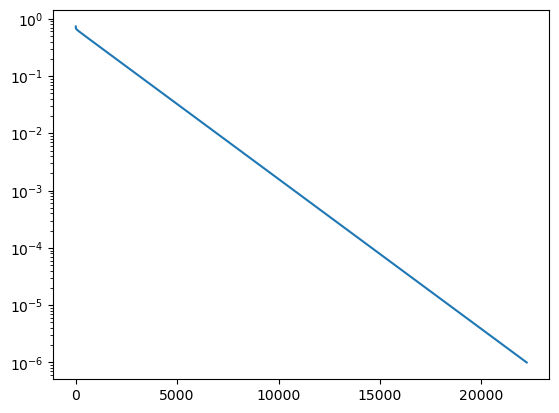

In [10]:
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1]).item() 
res_arr = [res]
print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test)
    residual = grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1]).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_thermalfield(u_test[0], "U_test")
plot.plot_thermalfield(solution_test[0], "U_train")
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

In [14]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        '''
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, self.ku, kernel_size=1, padding=0),
            nn.BatchNorm2d(num_features=self.ku),
            nn.Unfold(kernel_size=3, padding=1),
            nn.Sigmoid()
            )
        '''
        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        
        #bs0, ku0, h0, w0 = x.size()
        #new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention = self.attention_map(m).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention_x = new_x * attention # shape (bs, ku, 9, h, w)
        #attention_x = attention_x.sum(dim=2) # shape (bs, ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [15]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 batch_size=8,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=3, mode=mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, h, v, f, t, t_idx, d, d_idx, m, num_sweeps_down):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(h, u, f, t, t_idx, d, d_idx, m)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(self.h, uu, f_train, traction_value_train, traction_idx_train, dirich_value_train, dirich_idx_train, material_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

Step-0 loss: 1219348.225181286
Step-50 loss: 1140655.7159840672
Step-100 loss: 1145696.9059107
Step-150 loss: 1143076.7374469154
Step-200 loss: 1147761.7921427083
Step-250 loss: 1149840.2135001144
Step-300 loss: 1144289.207261175
Step-350 loss: 1145288.55642546
Step-400 loss: 1146444.067819572
Step-450 loss: 1148653.327138581
Step-500 loss: 1142135.923179993
Step-550 loss: 1151861.3865524458
Step-600 loss: 1132393.8137705824
Step-650 loss: 1148738.6426367261
Step-700 loss: 1147339.3619218674
Step-750 loss: 1139266.8744482612
Step-800 loss: 1146611.777841476
Step-850 loss: 1138338.125339856
Step-900 loss: 1141783.9592070985
Step-950 loss: 1148298.297408565
Average loss:  tensor(1143549.2500) , STD:  tensor(4608.5303)


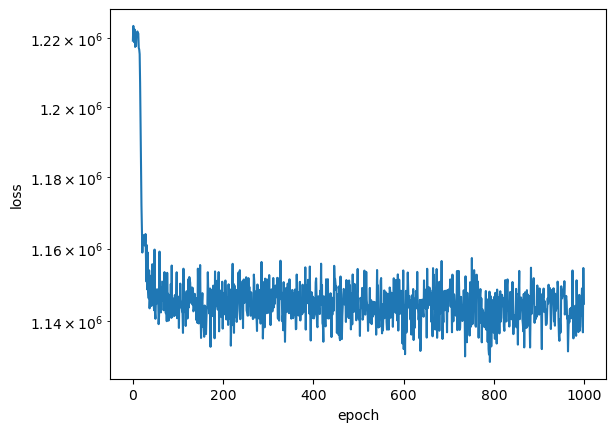

In [16]:
my_iterator = PsiIterator(device, batch_size=bs)
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


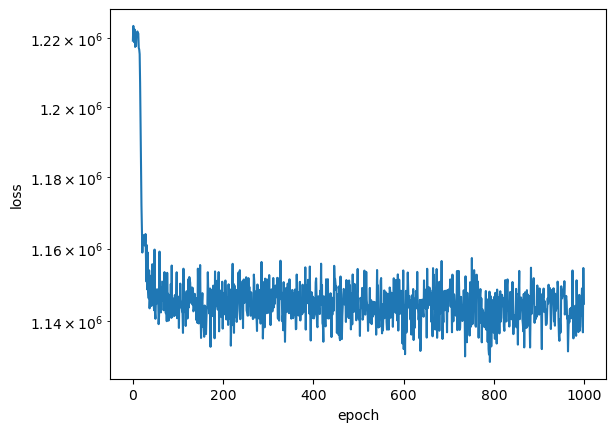

In [17]:
# import the learned model and loss train
my_net = PsiNet(mode='thermal').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, psi_net=my_net, grid=grid, batch_size=1)

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 0.732643063485908
1 1.8318246260075166
2 11.597788946067451
3 32.85310932552895
4 114.38164580701205
5 369.8654555758744
6 1388.1828623520073
7 5460.60562417102
8 23641.402712356055
9 106706.67337354226
10 496000.1380185835
11 2348459.8415368036
12 11210057.302296912
13 53906250.559245594
14 259497386.77274054
15 1249313785.37634
16 5995960201.800721
17 28689200302.411377
18 136894468466.8468
19 653059156370.2161
20 3124610268409.457
21 15049120865099.08
22 73154096614754.34
23 359148264105718.1
24 1777791392488410.0
25 8841960830372746.0
26 4.400258906227859e+16
27 2.182813318646388e+17
28 1.0763102977046185e+18
29 5.266737213499335e+18
30 2.5567591843832242e+19
31 1.2325392103585292e+20
32 5.913585756906774e+20
33 2.833520909651759e+21
34 1.361638962277063e+22
35 6.590080132717566e+22
36 3.222118983409958e+23
37 1.5928921613792651e+24
38 7.948941555493855e+24
39 3.990118304471451e+25
40 2.0062201191193126e+26
41 1.006416269927142e+27
42 5.02164406563931e+27
43 2.4870887668906426e+2

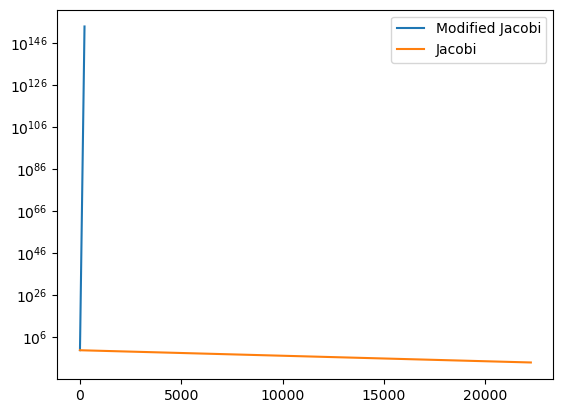

In [18]:
EPS = 1e-6
n_new = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = new_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1]).item() # fix top, apply traction force at bottom boundary
res_arr_new = [res]
print(n_new, res)
while (abs(res) > EPS):
    u_test = new_iterator.PsiRelax(h, u_test, f_test, t_test, t_idx_test, d_test, d_idx_test, m_test, 1)
    residual = new_iterator.grid.net(h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1]).item()
    res_arr_new.append(res)
    n_new += 1
    print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()